# Analiza zmiany wartości mid price na podstawie Limit Order Book

Celem projektu jest analiza zmiany mid price na podstawie wartości w Limit Order Book. Chcemy uzyskać klasyfikator, który pozwoli na przewidzenie czy wartość mid price w kolejnej chwili zwiększy się, bądź zmalaje.

In [1]:
from imbalance import prep_data
from parser import parse
from utils import confusion_matrix
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

file_locs = ['data/OrderBookSnapshots.9061.csv', 'data/OrderBookSnapshots.9062.csv', 'data/OrderBookSnapshots.9063.csv',
             'data/OrderBookSnapshots.9064.csv', 'data/OrderBookSnapshots.9065.csv']

## Imbalance

Praca "Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book" (https://arxiv.org/abs/1512.03492) opisuje jeden sposób na stworzenie takiego klasyfikatora. Autorzy używają w niej wartości imbalance, to jest unormowana różnica pomiędzy ilościami zleceń dla najlepszej możliwej ceny sprzedaży i kupna.

Plik imbalance.py zawiera program wykorzystujący imbalance do klasyfikacji. Część bez przygotowania danych jest przepisana poniżej. Analizowany jest każdy z 5 plików danych. Dla każdego wypisujemy dokładność oraz confusion matrix (pierwszy wiersz to elementy którym klasyfikator przypisał wartość 0).

In [2]:
from sklearn import linear_model


for file_name in file_locs:
    X_train, Y_train, X_test, Y_test = prep_data(parse(file_name))
    classifier = linear_model.SGDClassifier(loss="log", alpha=0.1, max_iter=3000, tol=0, shuffle=False)
    classifier.fit(X_train, Y_train)
    Y_check = classifier.predict(X_test)
    print(classifier.score(X_test,Y_test))
    print(confusion_matrix(Y_check, Y_test))
    print()

0.5263157894736842
[[239 211]
 [230 251]]

0.512273212379936
[[186 167]
 [290 294]]

0.573170731707317
[[243 177]
 [208 274]]

0.518022657054583
[[153 136]
 [332 350]]

0.5721784776902887
[[178 126]
 [200 258]]



## Klasyfikator oparty na sieci neuronowej

In [3]:
import torch
from torch import nn
import numpy as np

W LOB jest jednak więcej danych niż sam imbalance. Chcemy sprawdzić jak bardzo pomagają nam dodatkowo informacje. Do analizy takiego zbioru danych użyjemy sieci neuronowej.

### Preprocessing

Zamiast brać słupki z LOB dzielimy cały zakres na kubełki, których wielkość to ułamek wartości mid price. Następnie bierzemy tylko kilka z każdej strony mid price i normujemy tak, aby wartości sumowały się do jedynki.


In [4]:
### plik preprocess.py

def fits(index, arr):
    return index >= 0 and index < len(arr)


def get_XY(data, n_buckets=5, bucket_size=0.05 , omit_no_change=True):
    
    keys = list(data.keys())
    keys.sort()

    
    bad0 = 0
    bad1 = 0

    growths = []
    X = []

    for i, curr in enumerate(keys[:-1]):
        currKey = curr
        nextKey = keys[i+1]

        currday, currh = currKey.split()
        nextday, nexth = nextKey.split()

        currh = int(currh[:4])
        nexth = int(nexth[:4])

        

        if currh < 900 or currh > 1600 or currh + 1 != nexth:
            bad0 += 1
            continue


        if not omit_no_change or data[nextKey][2] != data[currKey][2]:
            rows0 = np.zeros(2*n_buckets)
            rows = np.zeros(2*n_buckets)
            
            mid_price = data[currKey][2]
            centers = (np.arange(2*n_buckets) - n_buckets + 0.5)*bucket_size*mid_price + mid_price
            #print(mid_price, centers)

            #print(mid_price)
            for bid_price, bid_size in reversed(data[currKey][0]):
                bucket = int(( n_buckets*bucket_size -  (mid_price-bid_price)/mid_price)/bucket_size)
                #print(bucket)
                if fits(bucket, rows):
                    rows0[bucket] += bid_size
                    #norm += bid_size
                    norm = 0.
                    for i in range(len(rows)//2):
                        norm += 1. / max(1.*(abs(centers[i]-bid_price)/(mid_price*bucket_size))**2., 0.25)
                    check = 0.
                    for i in range(len(rows)//2):
                        rows[i] += bid_size* ( (1./max((abs(centers[i]-bid_price)/(mid_price*bucket_size))**2., 0.25)) / norm )
                        check += ( (1./max(1.*(abs(centers[i]-bid_price)/(mid_price*bucket_size))**2., 0.25)) / norm )

            for ask_price, ask_size in data[currKey][1]:
                bucket = int(((ask_price - mid_price)/mid_price )/bucket_size)
                #print(bucket + n_buckets)
                if fits(bucket + n_buckets, rows):
                    rows0[bucket + n_buckets] += ask_size
                    #norm += bid_size
                    norm = 0.
                    for i in range(len(rows)//2, len(rows)):
                        norm += 1. / max(1.*(abs(centers[i]-ask_price)/(mid_price*bucket_size))**2., 0.25)
                    for i in range(len(rows)//2, len(rows)):
                        rows[i] += ask_size* ( (1./max(1.*(abs(centers[i]-ask_price)/(mid_price*bucket_size))**2., 0.25)) / norm )

            # poprawne dane - min ask > max bid
            if data[currKey][0][-1][0] <  data[currKey][1][0][0] and data[nextKey][0][-1][0] <  data[nextKey][1][0][0]:
                growths.append(data[currKey][2] < data[nextKey][2])
                rows /= rows.sum() #norm
                rows0 /= rows0.sum()
                X.append(rows)
            else:
                bad1 += 1


    X = np.array(X, dtype=np.float32)
    Y = np.array(growths, dtype=np.int)

    test_size =  len(Y)//8

    #dzielenie na czesc do uczenia/walidacji i testowa
    return (X[test_size:], Y[test_size:]), (X[:test_size], Y[:test_size])


### Model

Po wielu próbach okazało się, że dysponując taką ilością danych nie opłaca sie robić głębokiej sieci neuronowej, zatem sieć jest stosunkowo płytka. Składa się z ona jedynie z jednej warstwy ukrytej i warstwy Dropout.

In [5]:
bucket_size = 0.04
input_size = 2*3
hidden_size = 1000

loss = nn.CrossEntropyLoss()

In [10]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(hidden_size, hidden_size//4),
    nn.ReLU(),
    nn.Linear(hidden_size//4, 2)

)

### Trening

Plik train.py zawiera klasę odpowiedzialną za trenowanie sieci. Aby uruchomić trenowanie należy użyć pliku main.py i podać ścieżkę do pliku z danymi.

Na początku algorytm szybko zaczyna cały czas przewidywać jedną klasę. Na koniec jednak zaczyna rozróżniać klasy, jednak nadal zwracając dokładność w okolicach 50%.

Przykładowe wartości confusion matrix po zakończeniu obliczeniu


Train confusion matrix: 
[[401 382]  
 [392 411]]
Validation confusion matrix:  
[[425 383]  
 [409 407]]  
 
Train confusion matrix:  
[[340 315]  
 [461 486]]  
Validation confusion matrix:  
[[347 355]  
 [450 469]]  
 
 
 Dodatkowo dla każdego zestawu danych uruchamiamy uczenie kilka razy i wybieramy ten o najniższej wartości loss dla najlepszego modelu.

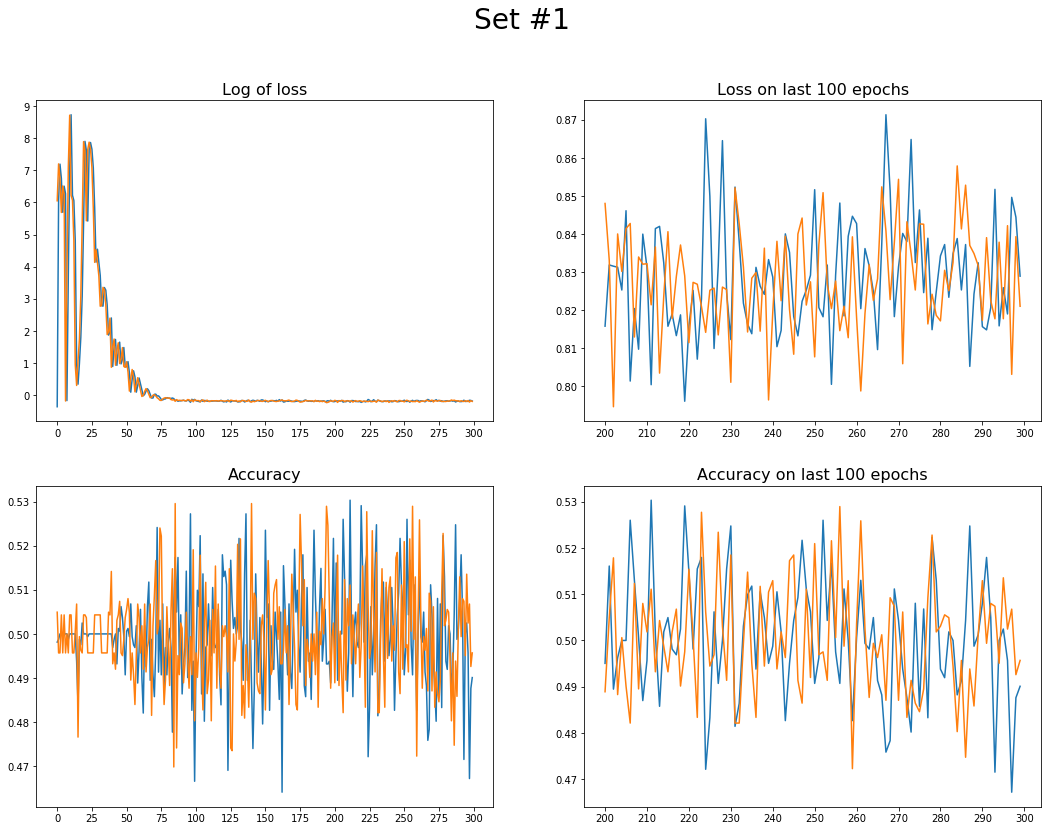

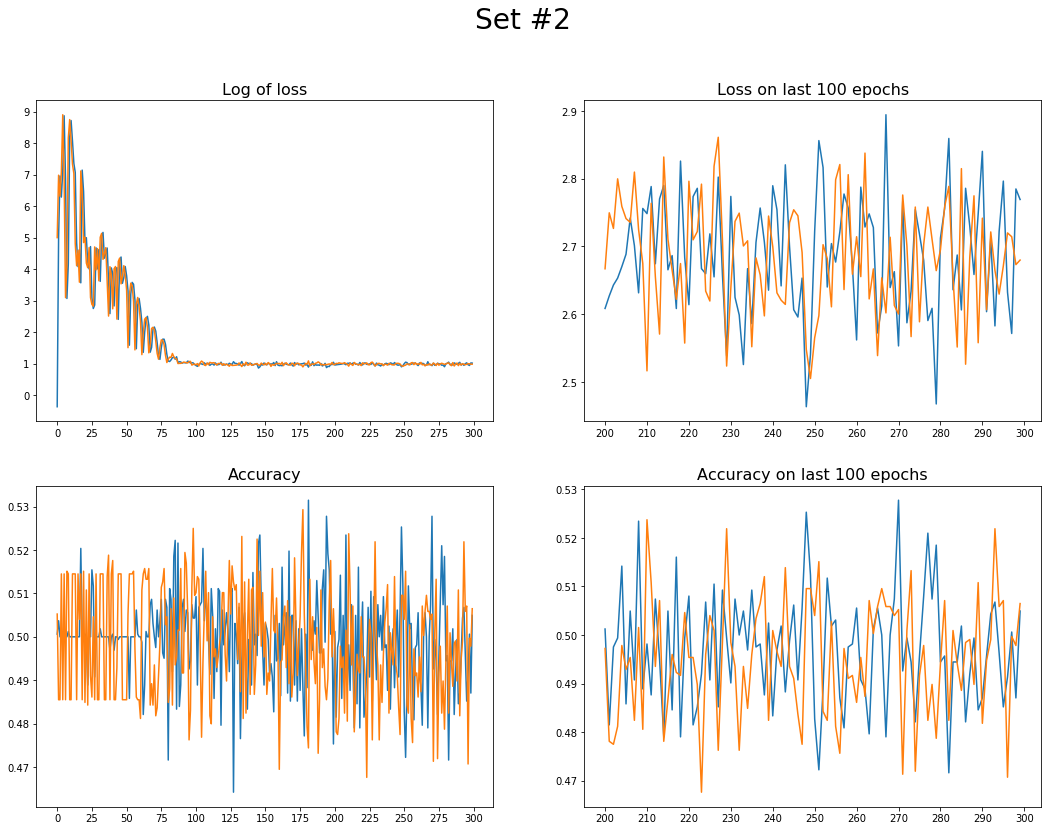

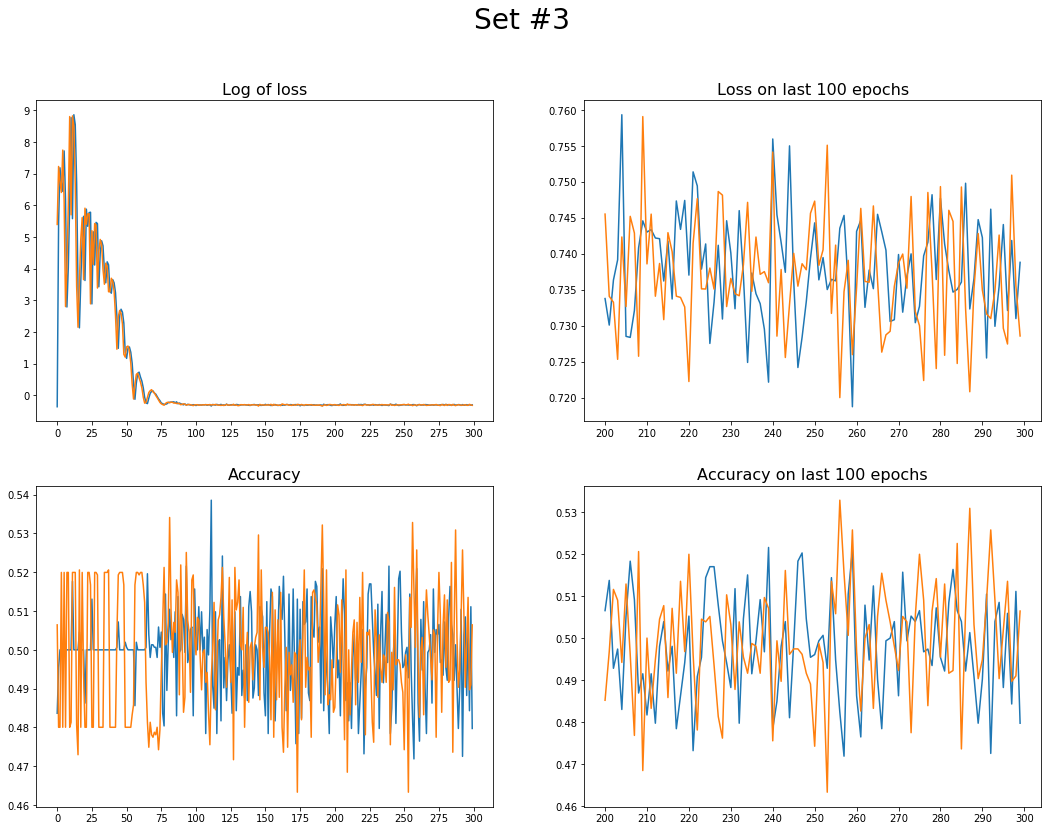

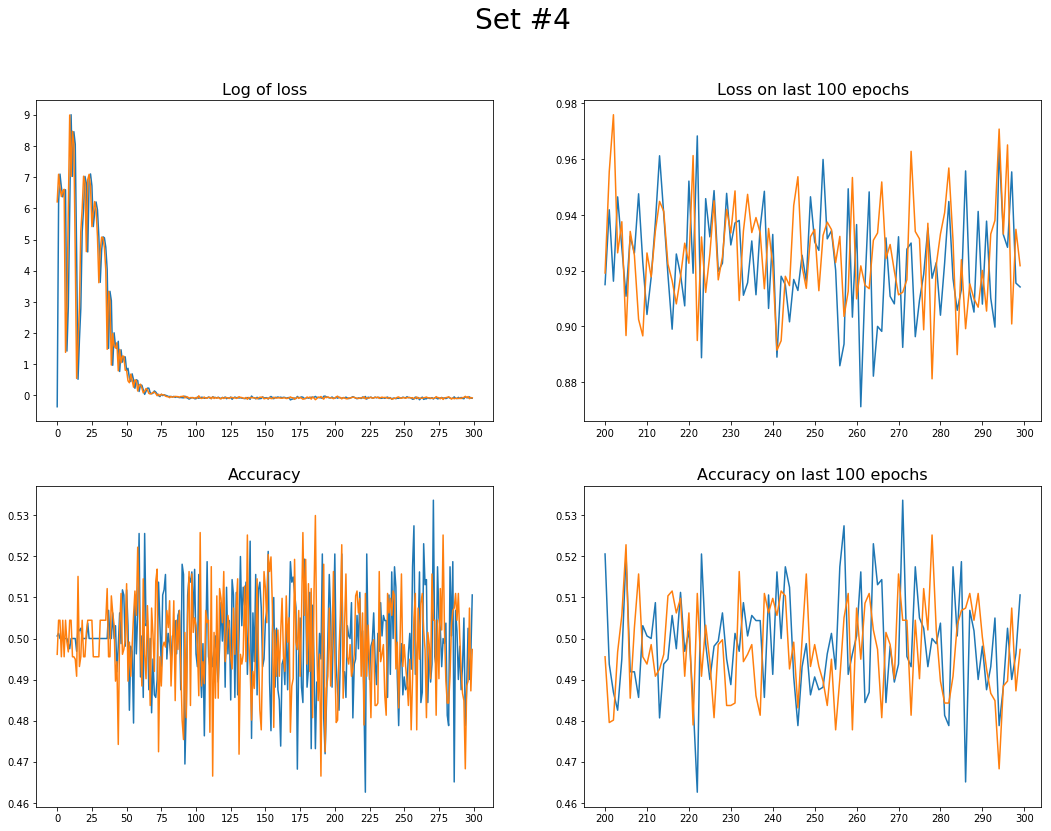

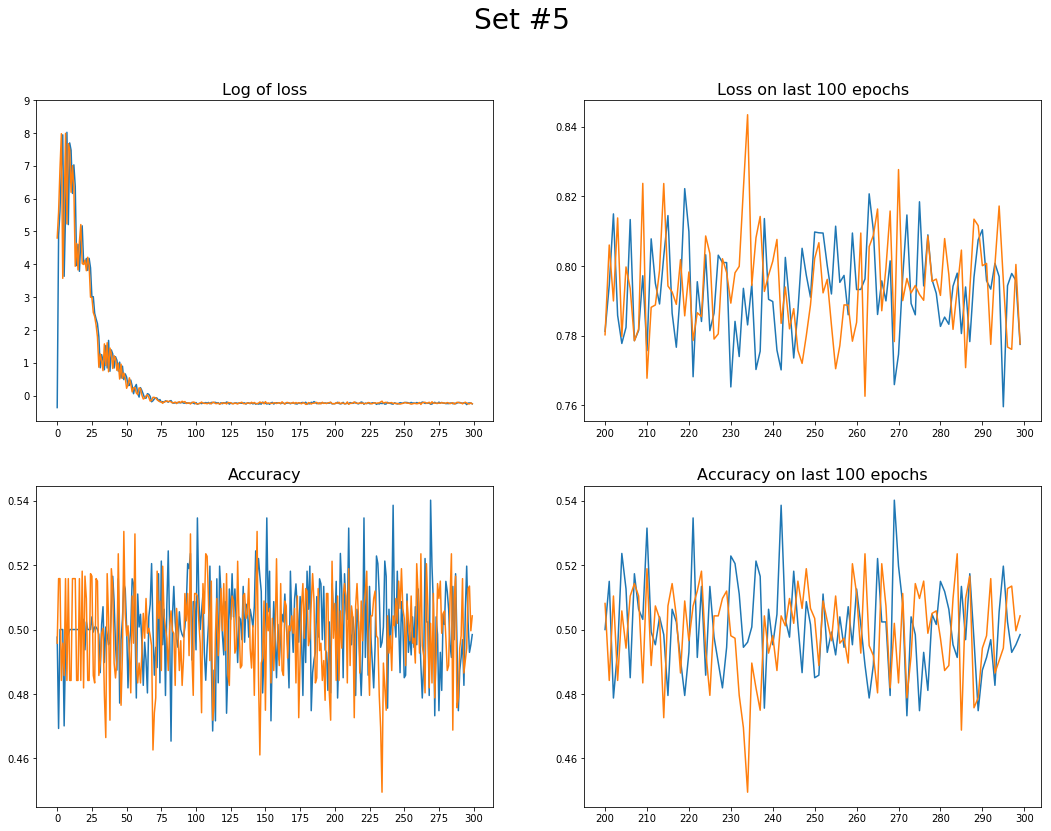

In [7]:

for i in range(1, 6):
    logs = pd.read_csv("logs/906"+str(i)+".csv")
    fig, axes = plt.subplots(2,2, figsize=(18,13))
    
    fig.suptitle("Set #{}".format(i), fontsize=28)
    
    axes[0][0].plot(np.log(logs["Train_loss"]))
    axes[0][0].plot(np.log(logs[" Validation_loss"]))
    axes[0][0].set_yticks(range(10))
    axes[0][0].set_xticks(range(0,301,25))
    axes[0][0].set_title("Log of loss", fontsize=16)
    
    axes[0][1].plot(logs["Train_loss"][-100:])
    axes[0][1].plot(logs[" Validation_loss"][-100:])
    #axes[0][0].set_yticks(range(10))
    axes[0][1].set_xticks(range(200,301,10))
    axes[0][1].set_title("Loss on last 100 epochs", fontsize=16)
    
    axes[1][0].plot(logs[" Train_acc"])
    axes[1][0].plot(logs[" Validation_acc"])
    axes[1][0].set_xticks(range(0,301,25))
    axes[1][0].set_title("Accuracy", fontsize=16)
    
    axes[1][1].plot(logs[" Train_acc"][-100:])
    axes[1][1].plot(logs[" Validation_acc"][-100:])
    axes[1][1].set_xticks(range(200,301,10))
    axes[1][1].set_title("Accuracy on last 100 epochs", fontsize=16)
    
    
    plt.show()

## Wyniki

Na końcu sprawdzamy jak klasyfikator radzi sobie na danych nie widzianych podczas uczenia

In [11]:
from utils import accuracy

from preprocess import get_XY

for data in file_locs:
    _, (X, Y) = get_XY(parse(data), n_buckets=input_size//2, bucket_size=bucket_size)
    
    set_number = data[data.find('.')+1:data.rfind('.')]
    
    model.load_state_dict(torch.load("models/model"+set_number))
    model.eval()
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    pred = model.forward(X)
    loss_val = loss(pred, Y)
    print("Loss: {}".format(loss_val.item()))
    print("Acc: {}".format(accuracy(pred.data.numpy(), Y.data.numpy())))
    print("Confusion matrix: ")
    print(confusion_matrix(np.argmax(pred.data.numpy(), axis=1), Y.data.numpy()))
    print()
    
## python3 main.py --data ../data/OrderBookSnapshots.9062.csv --debug --epochs 250 --buckets 3 --bucket_size 0.04 --print_every 100 --hidden 1000

Loss: 0.6931464076042175
Acc: 0.5064655172413793
Confusion matrix: 
[[  0   0]
 [229 235]]

Loss: 0.6933713555335999
Acc: 0.4838012958963283
Confusion matrix: 
[[224 239]
 [  0   0]]

Loss: 0.6962774395942688
Acc: 0.49774774774774777
Confusion matrix: 
[[  0   0]
 [223 221]]

Loss: 0.6963781118392944
Acc: 0.495850622406639
Confusion matrix: 
[[  0   0]
 [243 239]]

Loss: 0.6943790912628174
Acc: 0.45675675675675675
Confusion matrix: 
[[ 33  53]
 [148 136]]



## Krótka Analiza

Jak widać klasyfikator nie osiąga dobrych efektów. Pomimo, iż sieć uczy się pewnych zależności często niewidziane dane klasyfikuje tylko na jeden sposób. Może to świadczyć o tym, że podczas preprocessingu zbyt wiele danych uśredniamy poprzez wrzucanie ich do tego samego kubełka. Przez to kluczowe informacje, które są obecne w mierze takiej jak imbalance nie występują w naszej reprezentacji danych.

Dziękujemy za uwagę